In [145]:
#Dependências

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.odr as odr

In [140]:
## Definições

pickle_path = "output.pkl"
dict_renda = {"A": 0, "B": 0.5, "C": 1.25, "D": 1.75, "E": 2.25, "F": 2.75, "G": 3.5,
              "H": 4.5, "I": 5.5, "J": 6.5, "K": 7.5, "L": 8.5, "M": 9.5, "N": 11,
             "O": 13.5, "P": 17.5, "Q": 23}

rendas = np.array([dict_renda[k] for k in dict_renda.keys()])
rendas.sort()
xerr = []
for i in range(len(rendas) - 1):
    err = (rendas[i + 1] - rendas[i]) / np.sqrt(12)
    xerr.append(err)
xerr.append(6 / np.sqrt(12))

In [2]:
## Carregar dados

output = None

with open(pickle_path, "rb") as fid:
    output = pkl.load(fid)
    
raw = pd.DataFrame(output)

In [40]:
## Converter dados, filtrar e gerar pontuação total

cols = ["NU_NOTA_CH", "NU_NOTA_CN", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]

raw[cols] = raw[cols].apply(pd.to_numeric)
total = raw[cols[0]] + raw[cols[1]] + raw[cols[2]] + raw[cols[3]] + raw[cols[4]]
raw["total"] = total

inds = np.isfinite(raw[cols[0]])
inds &= np.isfinite(raw[cols[2]])
raw = raw[inds]

In [246]:
def plot_raca(dataframe, cor):
    inds = (dataframe.TP_COR_RACA == cor)
    tdat = dataframe[inds]
    
    N = len(dict_renda.keys())    
    x = np.zeros(N)
    y = np.zeros(N)
    std_y = np.zeros(N)
    n_y = np.zeros(N)
    frac = len(tdat) / len(dataframe)
    
    i = 0
    for key in dict_renda.keys():
        
        r_inds = (tdat.Q006 == key)
        rdat = tdat.total[r_inds]
        x[i] = dict_renda[key]        
        y[i] = np.median(rdat)
        std_y[i] = np.std(rdat)
        n_y[i] = len(rdat)
        i += 1
    
    output = {"renda": x, "pontuacao_media": y,
              "pontuacao_std": std_y, "frac": frac,
             "n" : n_y}
    return pd.DataFrame(output).sort_values("renda")

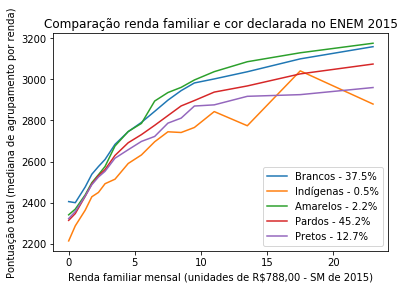

In [247]:
dict_cor = {"1": "Brancos", "2": "Pretos", "3": "Pardos",
            "4": "Amarelos", "5": "Indígenas"}


for key in dict_cor.keys():
    plotdata = plot_raca(raw, key)
    x = plotdata.renda
    y = plotdata.pontuacao_media
    yerr = plotdata.pontuacao_std
    frac = plotdata.frac
    label = "%s - %.1f%%" % (dict_cor[key], frac[0] * 100)
    plt.errorbar(x, y, label=label)

plt.title("Comparação renda familiar e cor declarada no ENEM 2015")
plt.ylabel("Pontuação total (mediana de agrupamento por renda)")
plt.xlabel("Renda familiar mensal (unidades de R$788,00 - SM de 2015)")
plt.legend()
plt.show()

In [248]:
plotdata = plot_raca(raw, "1")

In [252]:
x = np.array(plotdata.renda)
y = np.array(plotdata.pontuacao_media)
xerr = xerr
yerr = np.array(plotdata.pontuacao_std)
n_y = np.array(plotdata.n)

In [250]:
def f(B, x):
    return B[0] * np.sqrt(B[1] * x + B[2]) + B[3]

In [258]:
model = odr.Model(f)
data = odr.RealData(x, y, sx=xerr, sy=yerr/n_y)
myodr = odr.ODR(data, model, beta0=[1500, 100, 100, 100])
op = myodr.run()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [259]:
op.pprint()

Beta: [   23.40145579   116.93295748    53.45610669  2169.783729  ]
Beta Std Error: [  8.87889379e+05   8.87326584e+06   4.05645796e+06   1.32321888e+02]
Beta Covariance: [[  1.92886291e+11  -1.92764029e+12  -8.81230419e+11   9.54011236e+06]
 [ -1.92764029e+12   1.92641844e+13   8.80671845e+12  -9.53415231e+07]
 [ -8.81230419e+11   8.80671845e+12   4.02603549e+12  -4.35889099e+07]
 [  9.54011236e+06  -9.53415231e+07  -4.35889099e+07   4.28397586e+03]]
Residual Variance: 4.087110318334587
Inverse Condition #: 1.6561653659317168e-09
Reason(s) for Halting:
  Iteration limit reached


In [260]:
op.beta

array([   23.40145579,   116.93295748,    53.45610669,  2169.783729  ])

In [261]:
xm = np.linspace(0, 23, 100)
ym = f(op.beta, xm)

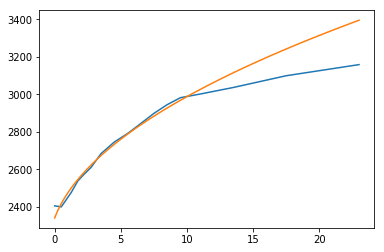

In [262]:
plt.plot(x, y)
plt.plot(xm, ym)
plt.show()

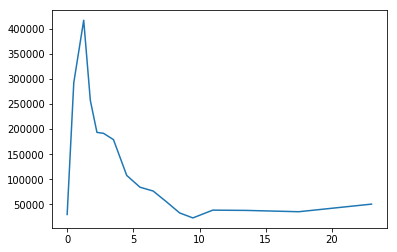

In [264]:
plt.plot(x, n_y)
plt.show()